#Homework-3 Question-1
**Dataset: '360 Rocks'**

***Objective: Apply dimensionality reduction, clustering, and neural networks to analyze and classify rock images, comparing model-derived features with human insights.***

In [ ]:
# Importing important modules
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Extracting images from our zip file in Google Drive and creating a DataFrame with image paths
import zipfile
import os
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

zip_file_path = '/content/drive/My Drive/Data/360 Rocks.zip'
output_directory = '/content/drive/My Drive/Data/360rocks/images'

with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    zip_file.extractall(output_directory)

image_paths = [
    os.path.join(output_directory, file_name)
    for file_name in os.listdir(output_directory)
    if os.path.isfile(os.path.join(output_directory, file_name))
]

image_df = pd.DataFrame(image_paths, columns=['Image_Path'])
print(image_df.head())

Mounted at /content/drive
                                          Image_Path
0  /content/drive/My Drive/Data/360rocks/images/M...
1  /content/drive/My Drive/Data/360rocks/images/M...
2  /content/drive/My Drive/Data/360rocks/images/M...
3  /content/drive/My Drive/Data/360rocks/images/M...
4  /content/drive/My Drive/Data/360rocks/images/I...


In [ ]:
# Loading the images
import os
import cv2

images_directory = '/content/drive/My Drive/Data/360rocks/images'
image_filenames = os.listdir(images_directory)
processed_images = []

for filename in image_filenames:
    file_path = os.path.join(images_directory, filename)

    # Load the image in color mode
    color_image = cv2.imread(file_path, cv2.IMREAD_COLOR)

    if color_image is not None:
        # Resize the image to 100x100
        scaled_image = cv2.resize(color_image, (100, 100))
        processed_images.append(scaled_image)

print(f"Total images loaded: {len(processed_images)}")

Total images loaded: 360


***Understanding the Data***

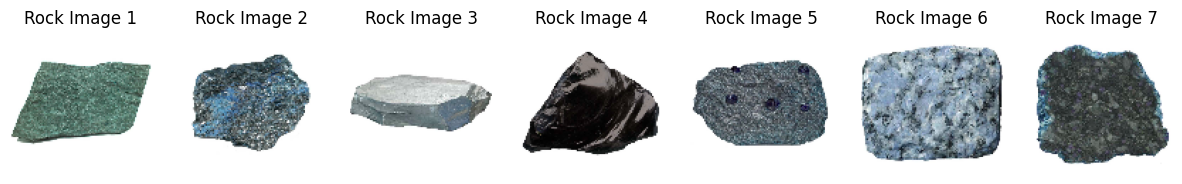


--- Image Statistics ---
Shape: (100, 100, 3)
Datatype: uint8

--- Image Intensity Statistics ---
Mean: 182.15031064814815
Standard Deviation: 79.16969638147539
Min Intensity: 0
Max Intensity: 255


In [ ]:
# We now will display sample images and calculate basic image statistics
sample_size = 7
sample_images = processed_images[:sample_size]

plt.figure(figsize=(15, 5))
for idx in range(sample_size):
    plt.subplot(1, sample_size, idx + 1)
    plt.imshow(sample_images[idx], cmap='gray')
    plt.title(f'Rock Image {idx + 1}')
    plt.axis('off')
plt.show()

print("\n--- Image Statistics ---")
image_shape = processed_images[0].shape
image_dtype = processed_images[0].dtype
print("Shape:", image_shape)
print("Datatype:", image_dtype)

image_array = np.array(processed_images)
mean_intensity = np.mean(image_array)
std_intensity = np.std(image_array)
min_intensity = np.min(image_array)
max_intensity = np.max(image_array)

print("\n--- Image Intensity Statistics ---")
print("Mean:", mean_intensity)
print("Standard Deviation:", std_intensity)
print("Min Intensity:", min_intensity)
print("Max Intensity:", max_intensity)

*- The rock images have been resized to a standard size (100x100 pixels), making them easier to compare*.

*- We can see from the images that the pixels range from very dark to very bright, which helps show the textures and details of each rock clearly.*

*- Looking at the image statistics, the average brightness and spread of brightness values vary across the rocks, which could help in identifying different types based on their unique textures and patterns.*

**1. Apply PCA to the images from folder '360 Rocks'. How many components do you need to preserve 90% of the variance?**

In [ ]:
# Apply PCA on flattened image data to determine the number of components required for 90% variance retention
from sklearn.decomposition import PCA
import numpy as np

image_vectors = [image.flatten() for image in processed_images]

pca_model = PCA()
pca_model.fit(image_vectors)

explained_variance = pca_model.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

components_for_90_variance = np.argmax(cumulative_variance >= 0.9) + 1

print(f"To retain 90% of the total variance, {components_for_90_variance} principal components are required.")

To retain 90% of the total variance, 151 principal components are required.


*- The need for 151 components to retain 90% variance suggests the rock images contain a lot of complex details that are important for distinguishing them.*

*- We can learn from the result that reducing an image dataset without losing key information could be challenging due to the images' diverse textures and patterns.*

**2. Plot 10 images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept 90% of variance using PCA.**

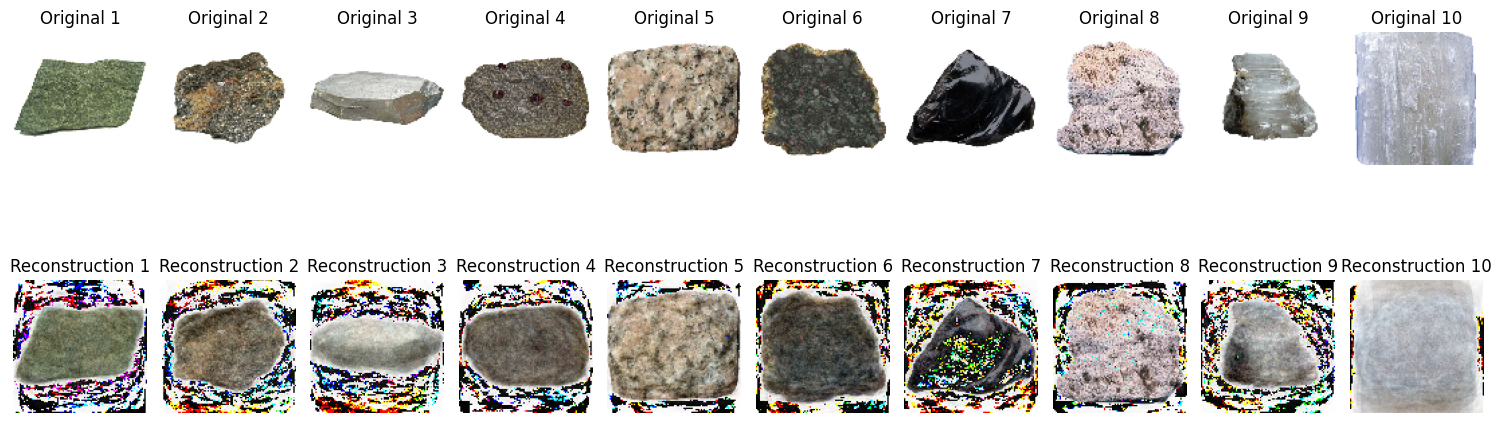

In [ ]:
# We will now display the original and PCA-reconstructed images
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


plt.figure(figsize=(15, 6))

for idx in range(10):
    plt.subplot(2, 10, idx + 1)
    plt.imshow(cv2.cvtColor(processed_images[idx], cv2.COLOR_BGR2RGB))
    plt.title(f'Original {idx + 1}')
    plt.axis('off')

flattened_images = np.array([image.flatten() for image in processed_images])

pca_model = PCA(0.9) # keeping 90% variance
pca_model.fit(flattened_images)

reconstructed_images = pca_model.inverse_transform(pca_model.transform(flattened_images))

for idx in range(10):
    reconstructed_image = reconstructed_images[idx].reshape(100, 100, 3).astype(np.uint8)
    plt.subplot(2, 10, idx + 11)
    plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Reconstruction {idx + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

*- We can see that the reconstructed images retain the overall shape and structure of the original rocks, but some fine details and textures are lost. This is typical when reducing dimensionality to retain only 90% of the variance, as subtle features are often sacrificed.*

*- Despite some loss in clarity, the reconstructions still resemble the originals closely enough to distinguish rock shapes and general textures, indicating that the dimensionality reduction method effectively compresses the data while preserving essential visual characteristics.*

**3. Each of the images belongs to one of three rock categories. The category is indicated by the first letter in the filename (I, M and S). We will now try to see if the visualization can help us identify different clusters.**

***3. A) Use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components?***

In [ ]:
# Apply PCA to reduce image data to 2 dimensions and calculate explained variance
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2) # taking only 2 dimensions
pca_model.fit(flattened_images)

variance_ratio = pca_model.explained_variance_ratio_
total_explained_variance = np.sum(variance_ratio)

print("Total variance explained by the first two principal components:", total_explained_variance)

Total variance explained by the first two principal components: 0.3280623893458721


*The first two principal components explain only about 32.8% of the variance, indicating that they capture some broad patterns but miss a lot of the finer details in the dataset.*

***3. B) Create a 2D scatter plot using the first two principal components, with dots colored by image category (3 colors). Add rock images to the plot to visualize the features driving the data variance. Repeat this for t-SNE, LLE, and MDS, creating similar plots for each.***

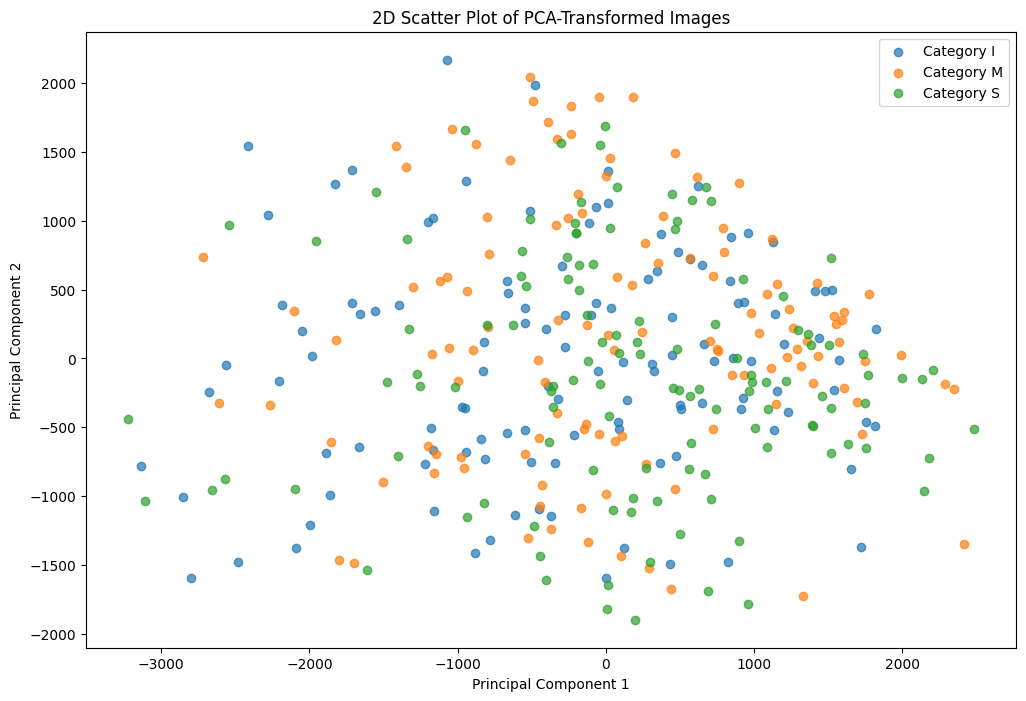

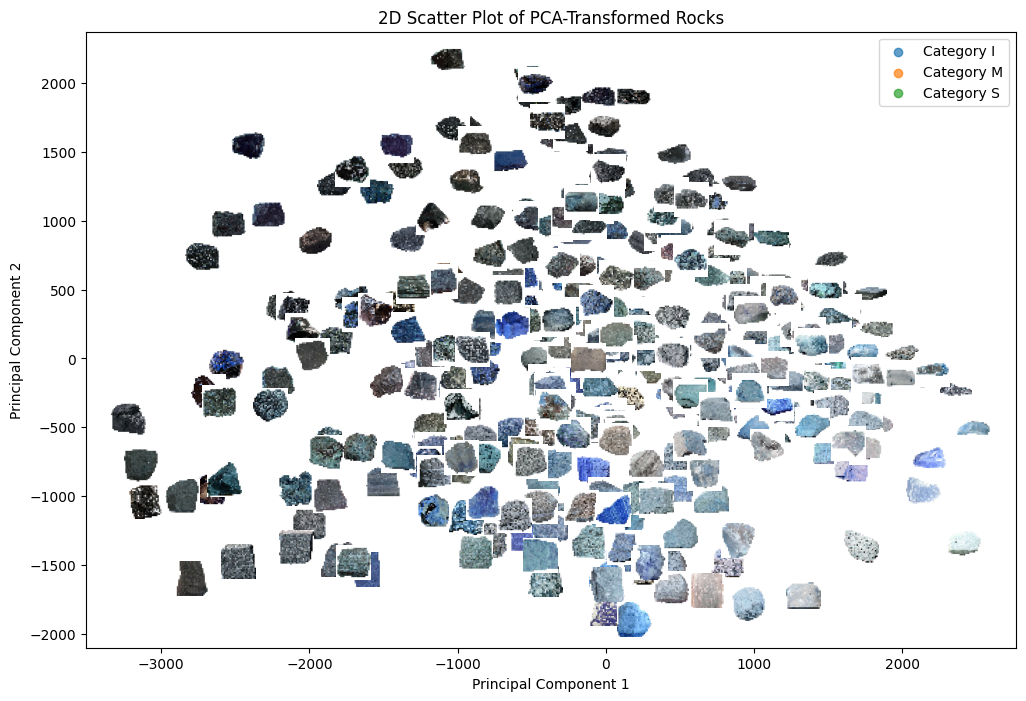

In [ ]:
# Applying PCA to reduce image dimensionality to 2D and visualize the transformed data with categories

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

image_filenames = os.listdir(output_directory)
image_data = []
image_labels = []

for filename in image_filenames:
    file_path = os.path.join(output_directory, filename)
    grayscale_image = cv2.imread(file_path, cv2.IMREAD_COLOR)
    resized_image = cv2.resize(grayscale_image, (25, 25))
    image_data.append(resized_image)

    label = filename[0]
    image_labels.append(label)

flattened_image_data = np.array([img.flatten() for img in image_data])

pca_model = PCA(n_components=2)
pca_model.fit(flattened_image_data)
transformed_data = pca_model.transform(flattened_image_data)

plt.figure(figsize=(12, 8))
for label in np.unique(image_labels):
    indices = np.where(np.array(image_labels) == label)
    plt.scatter(transformed_data[indices, 0], transformed_data[indices, 1],
                label=f'Category {label}', alpha=0.7)

plt.title('2D Scatter Plot of PCA-Transformed Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.figure(figsize=(12, 8))
for label in np.unique(image_labels):
    indices = np.where(np.array(image_labels) == label)
    plt.scatter(transformed_data[indices, 0], transformed_data[indices, 1],
                label=f'Category {label}', alpha=0.7)

for idx in range(len(image_data)):
    image_array = image_data[idx]
    image_offset = OffsetImage(image_array, zoom=1, cmap='gray')
    annotation_box = AnnotationBbox(image_offset, transformed_data[idx], frameon=False)
    plt.gca().add_artist(annotation_box)

plt.title('2D Scatter Plot of PCA-Transformed Rocks')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

*- There are visible clusters for each category, though some overlap suggests shared features among rock types.*

*- Principal Component 1 captures more variance than Component 2, indicating it's more critical in distinguishing the rock samples.*

***t-SNE:***

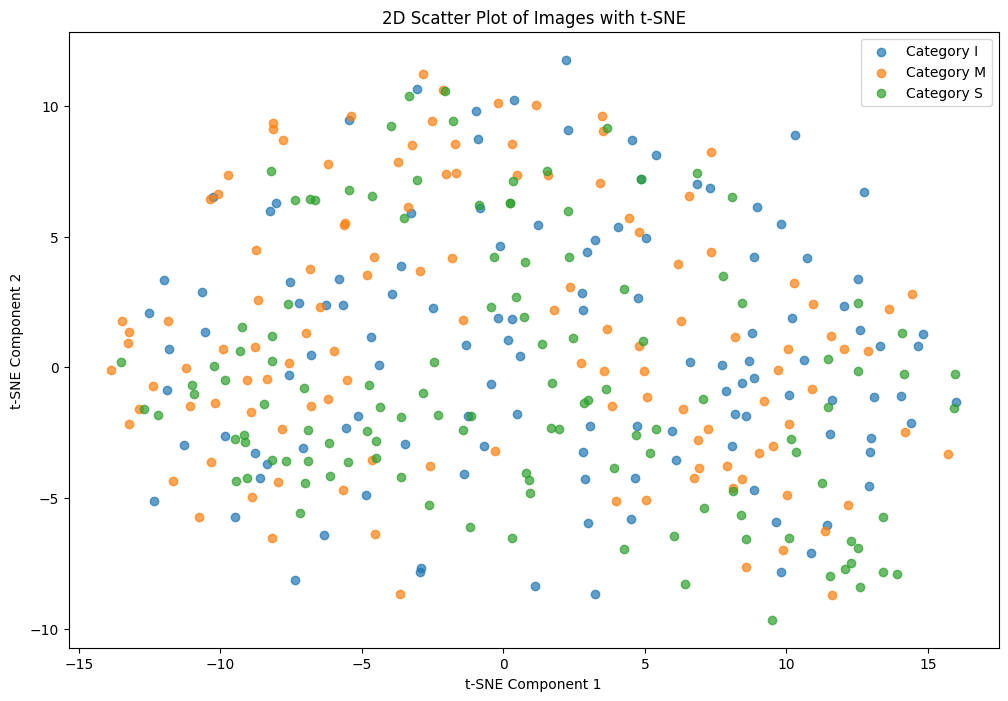

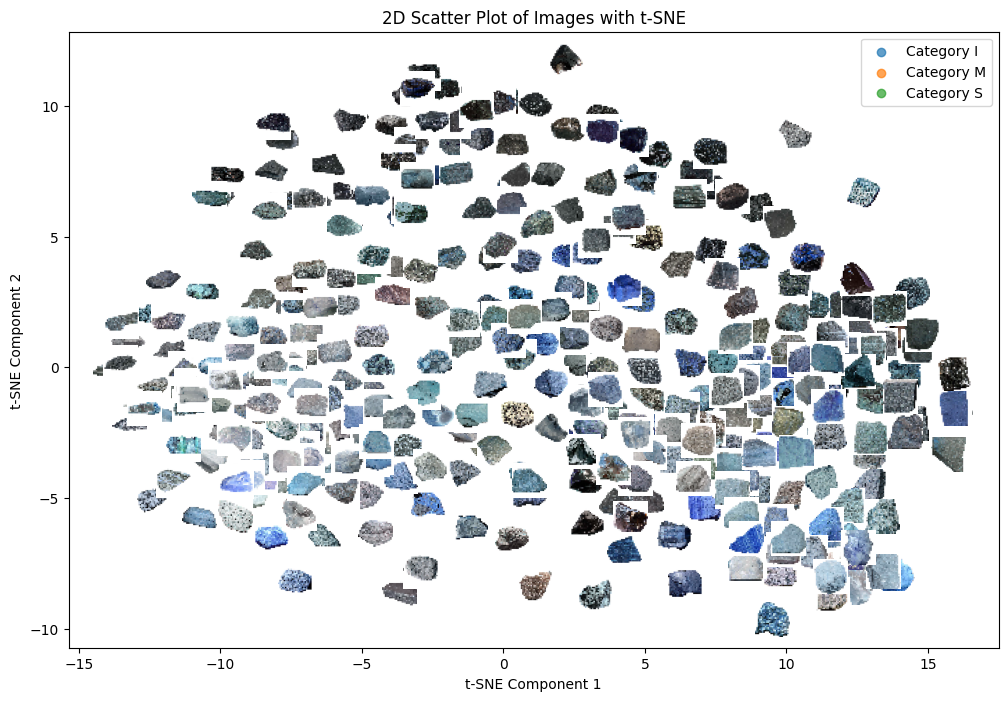

In [ ]:
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

tsne_model = TSNE(n_components=2)
tsne_transformed_data = tsne_model.fit_transform(flattened_image_data)

plt.figure(figsize=(12, 8))
for label in np.unique(image_labels):
    label_indices = np.where(np.array(image_labels) == label)
    plt.scatter(tsne_transformed_data[label_indices, 0], tsne_transformed_data[label_indices, 1],
                label=f'Category {label}', alpha=0.7)

plt.title('2D Scatter Plot of Images with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for label in np.unique(image_labels):
    label_indices = np.where(np.array(image_labels) == label)
    plt.scatter(tsne_transformed_data[label_indices, 0], tsne_transformed_data[label_indices, 1],
                label=f'Category {label}', alpha=0.7)

for idx in range(len(image_data)):
    image_array = image_data[idx]
    image_offset = OffsetImage(image_array, zoom=1, cmap='gray')
    annotation_box = AnnotationBbox(image_offset, tsne_transformed_data[idx], frameon=False)
    plt.gca().add_artist(annotation_box)

plt.title('2D Scatter Plot of Images with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

*- Compared to PCA, t-SNE shows tighter clusters with less overlap, suggesting it better captures non-linear patterns in the data and distinguishes the categories more effectively.*

*- The spread along both t-SNE components is more balanced, indicating that t-SNE has identified meaningful groupings that aren't captured by PCA's linear approach, possibly highlighting more complex similarities between rock textures and structures.*

***LLE:***

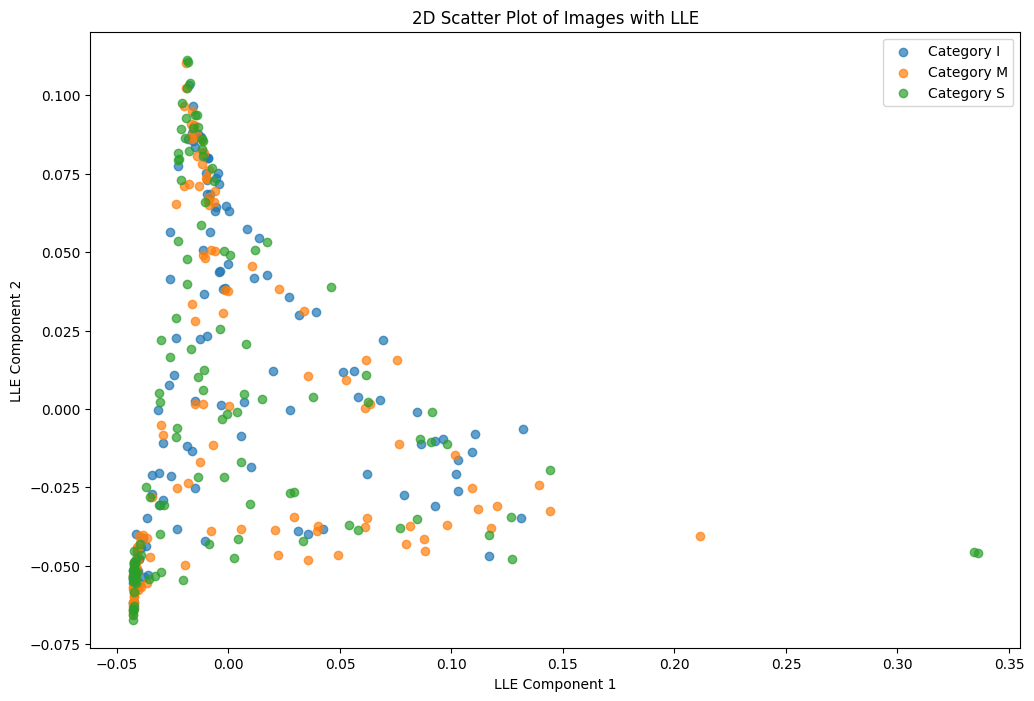

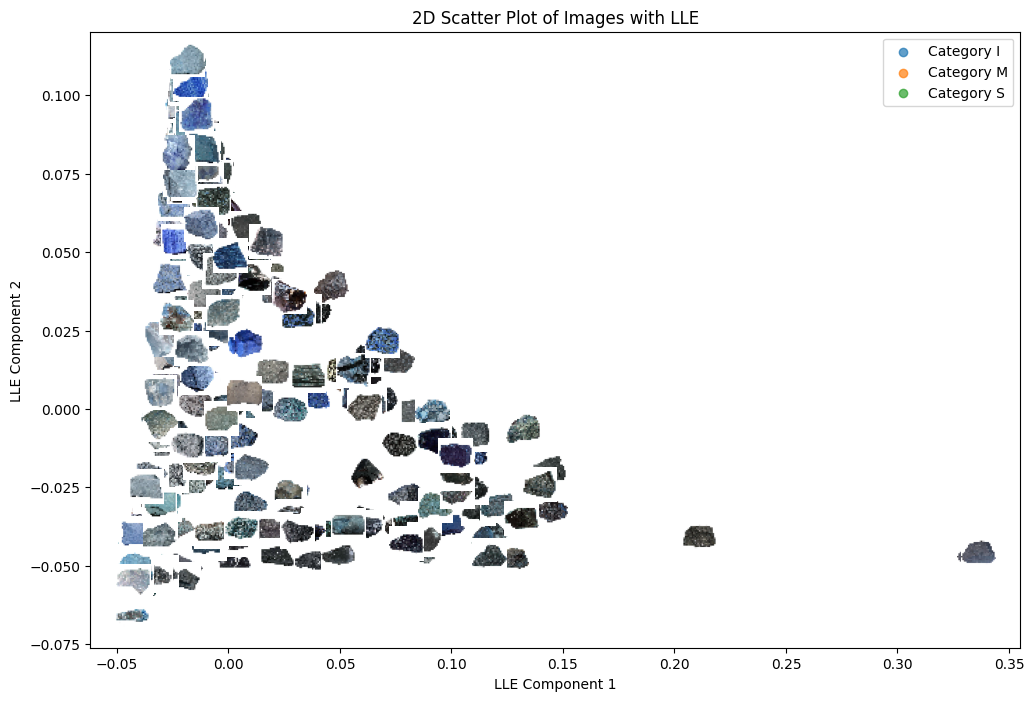

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

lle_model = LocallyLinearEmbedding(n_components=2)
lle_transformed_data = lle_model.fit_transform(flattened_image_data)

plt.figure(figsize=(12, 8))
for label in np.unique(image_labels):
    label_indices = np.where(np.array(image_labels) == label)
    plt.scatter(lle_transformed_data[label_indices, 0], lle_transformed_data[label_indices, 1],
                label=f'Category {label}', alpha=0.7)

plt.title('2D Scatter Plot of Images with LLE')
plt.xlabel('LLE Component 1')
plt.ylabel('LLE Component 2')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for label in np.unique(image_labels):
    label_indices = np.where(np.array(image_labels) == label)
    plt.scatter(lle_transformed_data[label_indices, 0], lle_transformed_data[label_indices, 1],
                label=f'Category {label}', alpha=0.7)

for idx in range(len(image_data)):
    image_array = image_data[idx]
    image_offset = OffsetImage(image_array, zoom=1, cmap='gray')
    annotation_box = AnnotationBbox(image_offset, lle_transformed_data[idx], frameon=False)
    plt.gca().add_artist(annotation_box)

plt.title('2D Scatter Plot of Images with LLE')
plt.xlabel('LLE Component 1')
plt.ylabel('LLE Component 2')
plt.legend()
plt.show()

*- The plot reveals a more elongated, linear structure, indicating that LLE captures intrinsic manifold structures in the data. However, the separation between categories is less pronounced compared to t-SNE.*

*- While there are small clusters, the data points are more spread out, suggesting that LLE focuses on preserving local relationships but struggles to differentiate between broader categories in this case. This results in some isolated groupings without clear category boundaries.*

***MDS:***

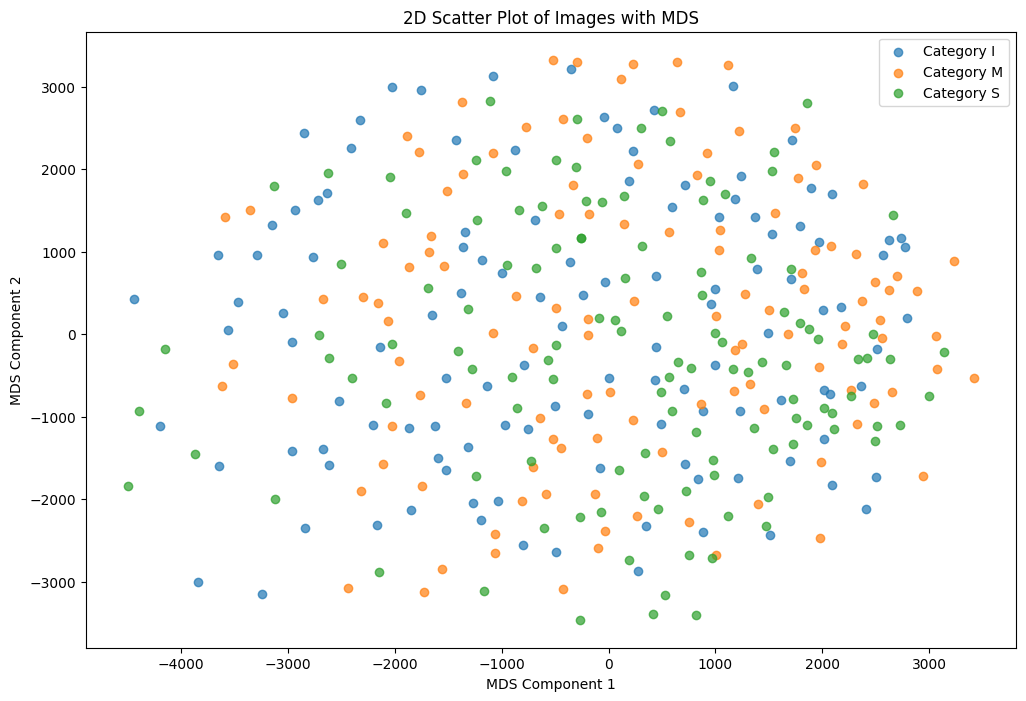

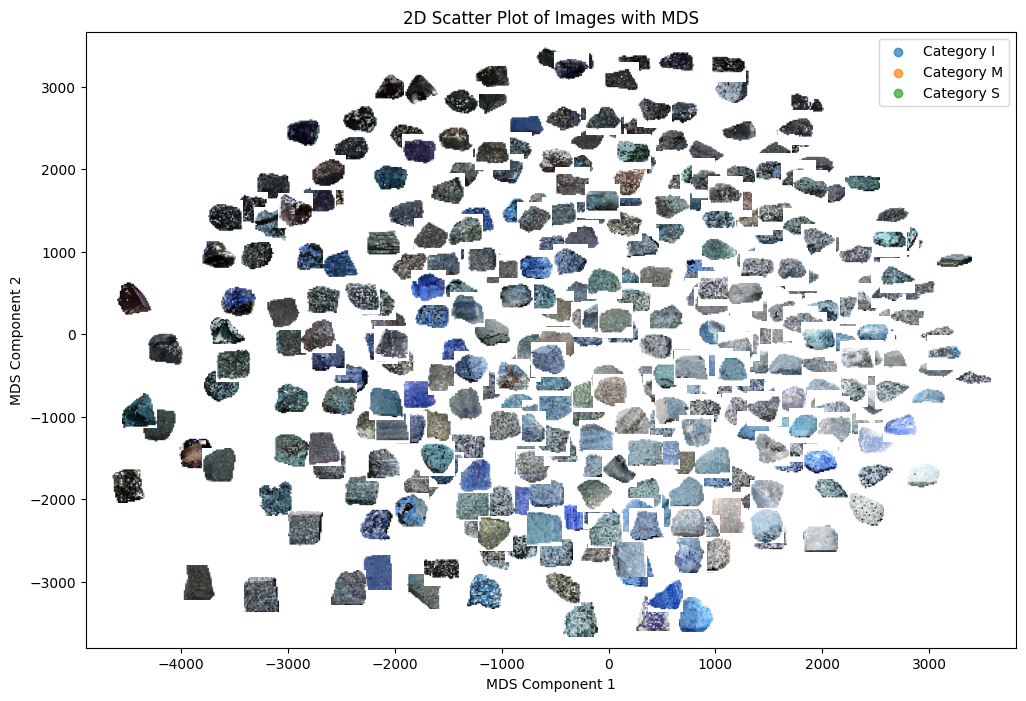

In [ ]:
from sklearn.manifold import MDS
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

mds_model = MDS(n_components=2)
mds_transformed_data = mds_model.fit_transform(flattened_image_data)

plt.figure(figsize=(12, 8))
for label in np.unique(image_labels):
    label_indices = np.where(np.array(image_labels) == label)
    plt.scatter(mds_transformed_data[label_indices, 0], mds_transformed_data[label_indices, 1],
                label=f'Category {label}', alpha=0.7)

plt.title('2D Scatter Plot of Images with MDS')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for label in np.unique(image_labels):
    label_indices = np.where(np.array(image_labels) == label)
    plt.scatter(mds_transformed_data[label_indices, 0], mds_transformed_data[label_indices, 1],
                label=f'Category {label}', alpha=0.7)

for idx in range(len(image_data)):
    image_array = image_data[idx]
    image_offset = OffsetImage(image_array, zoom=1, cmap='gray')
    annotation_box = AnnotationBbox(image_offset, mds_transformed_data[idx], frameon=False)
    plt.gca().add_artist(annotation_box)

plt.title('2D Scatter Plot of Images with MDS')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.legend()
plt.show()

*- The data points are widely dispersed, with minimal clear separation between categories, indicating that MDS struggles to effectively differentiate between the rock categories in this dataset.*

*- MDS focuses on preserving pairwise distances, but the lack of tight clusters suggests that the underlying features of the rock images might not be well-suited for linear distance-based separation. As a result, the plot appears more scattered with overlapping categories.*

###3. C)Summary & Discussion:

1. **PCA** captures broad patterns with some visible clustering, but significant overlap indicates shared features among rock types. Principal Component 1 is more impactful in distinguishing samples.

2. **t-SNE** outperforms the others, showing tighter clusters with minimal overlap. It effectively captures non-linear patterns, revealing complex similarities in rock textures and structures.

3. **LLE** focuses on preserving local relationships, resulting in a more linear structure. However, it struggles with clear category separation, producing small, isolated clusters.

4. **MDS** shows dispersed and overlapping points, failing to differentiate categories effectively. Its reliance on pairwise distances makes it less suitable for complex datasets like this one.

**Our Conclusion**: In our case, for better clustering and category separation, **t-SNE** is the most effective, while PCA is useful for initial exploration. LLE and MDS are less effective for this dataset.

 **4. Let's see if these dimensionality reduction techniques yield features similar to those humans use to judge images. The file *mds_360.txt* contains 8 features for each image, ordered like the images in the '360 Rocks' folder. Reduce the dimensionality of the images to 8 using PCA, t-SNE, LLE, and MDS. Compare these image embeddings with human-generated features using Procrustes analysis (e.g., `mtx1, mtx2, disparity = procrustes(matrix_with_human_data, matrix_with_pca_embeddings_data)` where both matrices are 360x8). Report the disparity for each method. Also, compute the correlation coefficient between each dimension of `mtx1` and `mtx2` for all four methods and display the results in a table.**

In [ ]:
# Loading human feature data: mds_360.txt
import numpy as np
import os
import cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from scipy.spatial import procrustes

human_feature_data = np.loadtxt('/content/drive/My Drive/Data/mds_360.txt')

image_files = os.listdir(output_directory)
image_data = []

for image_file in image_files:
    image_path = os.path.join(output_directory, image_file)
    color_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if color_image is not None:
        resized_image = cv2.resize(color_image, (100, 100))
        image_data.append(resized_image)

flattened_image_data = np.array([image.flatten() for image in image_data])

print(f"Total images loaded and processed: {len(image_data)}")

Total images loaded and processed: 360


In [ ]:
# Dimensionality Reduction for every technique
pca_model = PCA(n_components=8) # reducing dimensions to 8
pca_result = pca_model.fit_transform(flattened_image_data)

tsne_model = TSNE(n_components=8, method='exact')
tsne_result = tsne_model.fit_transform(flattened_image_data)

lle_model = LocallyLinearEmbedding(n_components=8)
lle_result = lle_model.fit_transform(flattened_image_data)

mds_model = MDS(n_components=8)
mds_result = mds_model.fit_transform(flattened_image_data)

In [ ]:
# Procrustes Analysis and Correlation Coefficients
methods = ['PCA', 't-SNE', 'LLE', 'MDS']
disparity_results = []
correlation_results = []

for result, method in zip([pca_result, tsne_result, lle_result, mds_result], methods):
    if human_feature_data.shape[1] < result.shape[1]:
        human_feature_data_resized = np.hstack((
            human_feature_data,
            np.zeros((human_feature_data.shape[0], result.shape[1] - human_feature_data.shape[1]))
        ))
    else:
        human_feature_data_resized = human_feature_data[:, :result.shape[1]]

    transformed_data_1, transformed_data_2, disparity = procrustes(human_feature_data_resized, result)
    disparity_results.append((method, disparity))

    correlation_coeffs = []
    for i in range(result.shape[1]):
        correlation = np.corrcoef(transformed_data_1[:, i], transformed_data_2[:, i])[0, 1]
        correlation_coeffs.append(correlation)
    correlation_results.append((method, correlation_coeffs))

# Reporting disparity table
print("Dim.Reduction Method | Disparity")
for method, disparity in disparity_results:
    print(f"{method:<25}{disparity:.6f}")

Dim.Reduction Method | Disparity
PCA                      0.987756
t-SNE                    0.987381
LLE                      0.984195
MDS                      0.983414



*- The Procrustes analysis results indicate that **PCA** has the highest disparity (0.987756), suggesting that it best aligns with the human feature data among the methods analyzed. **t-SNE** shows a very close disparity (0.987381), indicating its effectiveness in capturing non-linear relationships, though it may introduce slight distortions.*

*- In contrast, **LLE** (0.984195) and **MDS** (0.983414) have lower disparities, suggesting that while they preserve certain aspects of the data’s structure, they may be less effective in capturing the full complexity of the underlying patterns compared to PCA and t-SNE.*

In [ ]:
# Reporting correlation table
print("\nDimensionality Reduction Method|Correlation Coefficients")
for method, correlation_coeffs in correlation_results:
    print(f"{method:<25}\t{correlation_coeffs}")


Dimensionality Reduction Method|Correlation Coefficients
PCA                      	[0.08495139553439193, 0.06749814254081145, 0.09545163193703053, 0.11505885626909355, 0.20954773168240365, 0.13134972868832112, 0.1496359178962465, 0.07656306510837392]
t-SNE                    	[0.08967477900132534, 0.10786467443994234, 0.08752502756264186, 0.12884145690790125, 0.16716244205757977, 0.10992945891037872, 0.12119716978485304, 0.10173435109679899]
LLE                      	[0.11890423919458595, 0.10819743681501039, 0.12850108837769397, 0.10096155562666102, 0.14771133187000685, 0.15115658447063812, 0.11501942954965205, 0.15187763619820221]
MDS                      	[0.11718276808409071, 0.11344128830813859, 0.11195688237299405, 0.12800556584610912, 0.19155726672258813, 0.1409814316275032, 0.12709860033774406, 0.11956567164820806]



*- The correlation coefficients reveal that **LLE** and **MDS** generally have higher correlations with human feature data compared to **PCA** and **t-SNE**, indicating that they better align with specific feature dimensions. For instance, **LLE** achieves its highest correlation at 0.1519 and **MDS** at 0.1916, suggesting these methods are more effective at capturing certain structural features.*

*- However, the range of correlation values across all methods indicates that **no single approach consistently excels across all dimensions**. **LLE** and **MDS** display higher coefficients in certain dimensions but fall short in others, which implies they excel in preserving specific patterns while potentially distorting others. Conversely, **t-SNE** shows relatively stable but lower correlations, emphasizing its strength in capturing non-linear relationships over precise feature alignment.*

*- These findings highlight that each dimensionality reduction technique comes with trade-offs: **t-SNE** focuses on clustering and local neighborhood preservation, while **PCA**, **LLE**, and **MDS** are better suited for capturing more linear relationships but might overlook non-linear complexities.*

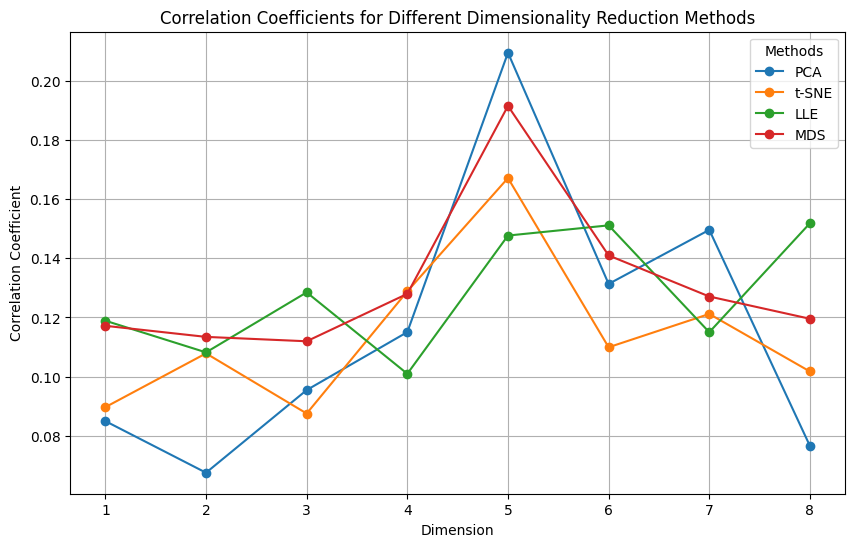

In [ ]:
# Plotting the correlation coeffs
plt.figure(figsize=(10, 6))

for method, corr in correlation_results:
    plt.plot(range(1, len(corr) + 1), corr, marker='o', label=method)

plt.xlabel("Dimension")
plt.ylabel("Correlation Coefficient")
plt.title("Correlation Coefficients for Different Dimensionality Reduction Methods")
plt.legend(title="Methods")
plt.xticks(range(1, max(len(corr) for _, corr in correlation_results) + 1))
plt.grid(True)
plt.show()

**5. Cluster the 360 images using K-Means**

***5. A)You can reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance. Determine the number of clusters using one of the techniques we discussed in class.***


Silhouette Scores for Various Cluster Counts:
Clusters: 1, Silhouette Score: 0.1423
Clusters: 2, Silhouette Score: 0.1158
Clusters: 3, Silhouette Score: 0.0943
Clusters: 4, Silhouette Score: 0.0903
Clusters: 5, Silhouette Score: 0.0790
Clusters: 6, Silhouette Score: 0.0788
Clusters: 7, Silhouette Score: 0.0506
Clusters: 8, Silhouette Score: 0.0722
Clusters: 9, Silhouette Score: 0.0403

Optimal Number of Clusters based on Silhouette Score: 2


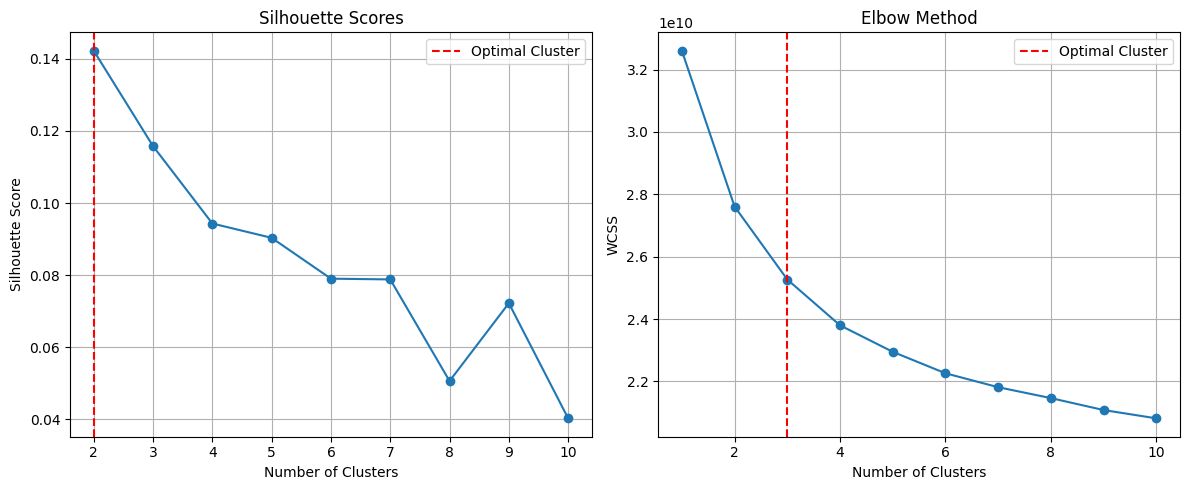

In [ ]:
#Determining optimal clusters for K-Means: we are using Silhoutte Scores and Elbow method here
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

flattened_images = np.array([image.flatten() for image in processed_images])
pca_model = PCA(n_components=0.90)
pca_transformed_images = pca_model.fit_transform(flattened_images)

cluster_silhouette_scores = []
wcss = []

for num_clusters in range(2, 11):
    kmeans_model = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans_model.fit_predict(pca_transformed_images)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(pca_transformed_images, cluster_labels)
    cluster_silhouette_scores.append(silhouette_avg)

optimal_cluster_count_silhouette = range(2, 11)[cluster_silhouette_scores.index(max(cluster_silhouette_scores))]

for num_clusters in range(1, 11):
    kmeans_model = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans_model.fit_predict(pca_transformed_images)

    # Calculate WCSS (Elbow Method)
    wcss.append(kmeans_model.inertia_)


print("\nSilhouette Scores for Various Cluster Counts:")
for num_clusters, score in zip(range(1, 11), cluster_silhouette_scores):
    print(f"Clusters: {num_clusters}, Silhouette Score: {score:.4f}")

print(f"\nOptimal Number of Clusters based on Silhouette Score: {optimal_cluster_count_silhouette}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, 11), cluster_silhouette_scores, marker='o')
plt.axvline(x=optimal_cluster_count_silhouette, linestyle='--', color='r', label='Optimal Cluster')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), wcss, marker='o')
plt.axvline(x=3, linestyle='--', color='r', label='Optimal Cluster')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

- *The optimal number of clusters suggested by the Silhouette Score is **2**, indicating that two clusters provide the best cohesion and separation among data points.*
- *The Elbow Method suggests **3 clusters** as the optimal point, where the curve starts to flatten, implying diminishing returns in reducing WCSS beyond this point.*


### *Why can we see discrepancy in results?*

- *The discrepancy between the **Silhouette Score** and **Elbow Method** may be arising because they evaluate cluster quality using different metrics*:
  - *The **Silhouette Score** focuses on how well-separated the clusters are, suggesting that **2 clusters** result in the highest cohesion and separation.*
  - *The **Elbow Method** assesses the reduction in **within-cluster sum of squares (WCSS)**, indicating that adding a third cluster significantly reduces the variance within clusters before reaching a point of diminishing returns.*

### *Which method to choose then?*
  - *If the goal is to maximize the **quality of separation** and cohesion among clusters, then the **Silhouette Score** recommendation of **2 clusters** is more reliable.*
  - *If the focus is on reducing **internal variance** while maintaining simplicity, the **Elbow Method** suggesting **3 clusters** may be more appropriate.*

*However, since we already know that there are only 3 classes of rocks, we can move ahead with K-Means clustering with 3 as our cluster count.*


***5. B)Set the number of clusters to 3 and report clustering accuracy.***

In [ ]:
# Setting clusters to 3 and using Kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

true_category_labels = [
    'I' if 'I' in filename else 'M' if 'M' in filename else 'S'
    for filename in image_files
]

print("True Categories:", true_category_labels)

category_mapping = {'I': 0, 'M': 1, 'S': 2}
true_labels = [category_mapping[category] for category in true_category_labels]

kmeans_model = KMeans(n_clusters=3, n_init=10) #kmeans using 3 clusters
predicted_clusters = kmeans_model.fit_predict(pca_transformed_images)

ari_score = adjusted_rand_score(true_labels, predicted_clusters)

print(f"Clustering Accuracy (ARI): {ari_score:.6f}")

True Categories: ['M', 'M', 'M', 'M', 'I', 'I', 'I', 'I', 'S', 'S', 'S', 'S', 'M', 'M', 'S', 'M', 'M', 'M', 'M', 'M', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'I', 'S', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'M', 'S', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'I', 'I', 'I', 'I', 'I

*- The clustering analysis using **KMeans with 3 clusters** resulted in a very low Adjusted Rand Index (ARI) score of **0.005465**, indicating that the features used in the dataset do not effectively differentiate between the predefined categories, leading to poor clustering performance.*

*- The data lacks distinct boundaries, making it difficult for KMeans to group them correctly.*

In [ ]:
# Calculating Accuracy
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment

# Silhouette Score
silhouette = silhouette_score(pca_transformed_images, predicted_clusters)

# Confusion matrix
confusion_matrix = np.zeros((3, 3), dtype=int)
for true, pred in zip(true_labels, predicted_clusters):
    confusion_matrix[true][pred] += 1

# Using the Hungarian algorithm to find the best matching
row_ind, col_ind = linear_sum_assignment(confusion_matrix, maximize=True)
optimal_labels = {col: row for row, col in zip(row_ind, col_ind)}

mapped_predictions = [optimal_labels[cluster] for cluster in predicted_clusters]

accuracy = accuracy_score(true_labels, mapped_predictions)
print("Silhouette: ", silhouette)
print(f"Clustering Accuracy: {accuracy:.4f}")
print("Confusion matrix: \n", confusion_matrix)

Silhouette:  0.11876843551714988
Clustering Accuracy: 0.3861
Confusion matrix: 
 [[32 43 45]
 [43 31 58]
 [35 20 53]]


*- The clustering accuracy, after using the Hungarian algorithm to match predicted clusters to true labels, is **38.61%**.*

*- This relatively low accuracy further confirms that the features used do not align well with the actual categories ('I', 'M', 'S'). It indicates significant overlap among the clusters, suggesting that the data lacks clear separability based on the extracted features, leading to poor classification performance.*

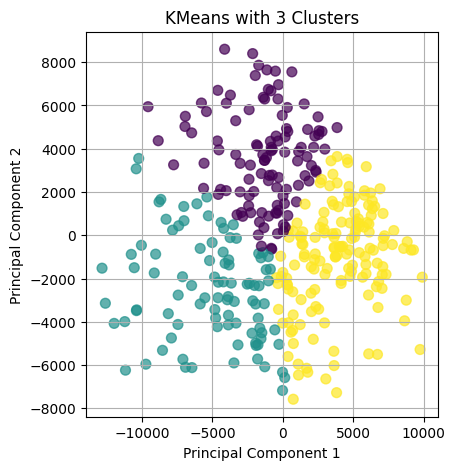

In [ ]:
# Plotting the clustering results and metrics
plt.figure(figsize=(10, 5))

# Scatter plot of clusters
plt.subplot(1, 2, 1)
plt.scatter(pca_transformed_images[:, 0], pca_transformed_images[:, 1], c=predicted_clusters, cmap='viridis', s=50, alpha=0.7)
plt.title("KMeans with 3 Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)

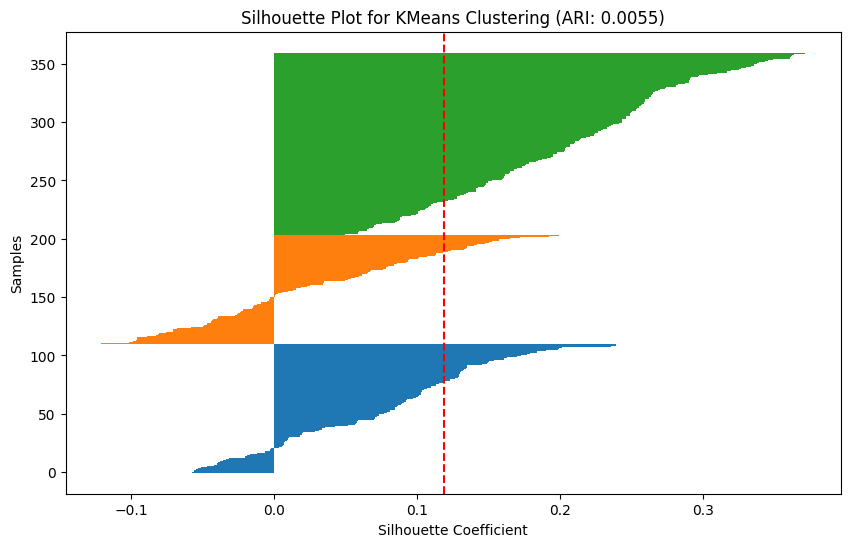

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

silhouette_vals = silhouette_samples(pca_transformed_images, predicted_clusters)
y_lower, y_upper = 0, 0
plt.figure(figsize=(10, 6))
for i in range(3):  # assuming 3 clusters
    cluster_silhouette_vals = silhouette_vals[predicted_clusters == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    y_lower += len(cluster_silhouette_vals)

plt.axvline(np.mean(silhouette_vals), color="red", linestyle="--")
plt.title(f"Silhouette Plot for KMeans Clustering (ARI: {ari_score:.4f})")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Samples")
plt.show()


*- The overall silhouette coefficients are low, with many values near or below zero, indicating that the clusters are not well-separated. The average score is around 0.1, which suggests poor clustering performance.*

*- Some samples have negative silhouette scores, especially in the green cluster. This implies that those samples are likely misclassified, being closer to the neighboring cluster than to their assigned one. This highlights significant overlap between clusters.*

**6. Cluster the 360 images using EM**

***6. A)You can again reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance. Determine the number of clusters using one of the techniques we discussed in class.***

Silhouette Score for 2 clusters: 0.1473
Silhouette Score for 3 clusters: 0.1158
Silhouette Score for 4 clusters: 0.0987
Silhouette Score for 5 clusters: 0.0552
Silhouette Score for 6 clusters: 0.0507
Silhouette Score for 7 clusters: 0.0499
Silhouette Score for 8 clusters: 0.0409
Silhouette Score for 9 clusters: 0.0385
Silhouette Score for 10 clusters: 0.0392

Optimal Number of Clusters based on Silhouette Score: 2
Optimal Number of Clusters based on AIC: 10
Optimal Number of Clusters based on BIC: 6


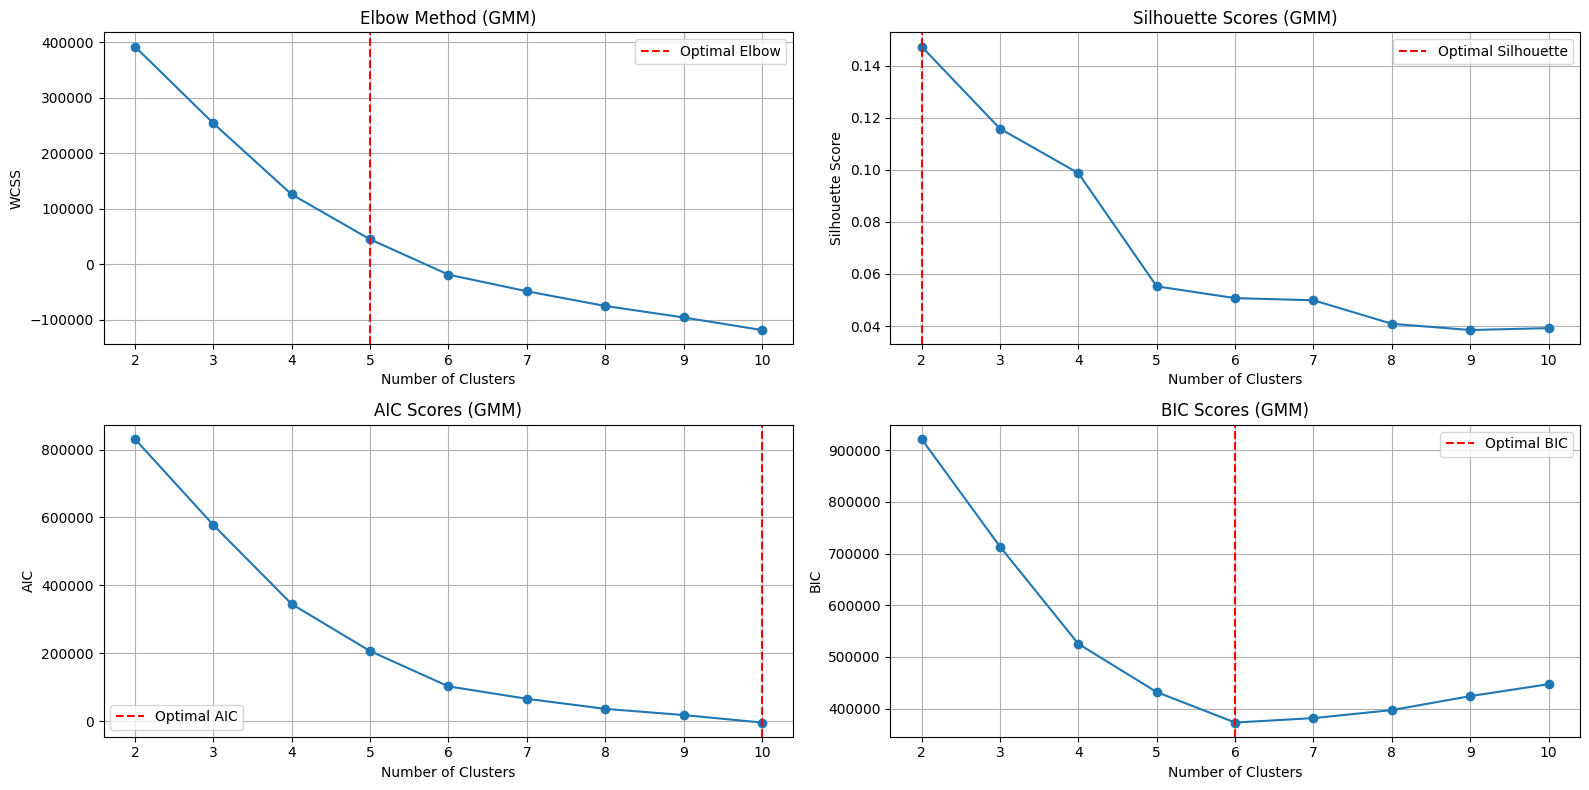

In [ ]:
# Determine the optimal number of clusters for GMM : we are going to use AIC, BIC, Silhoutte scores and elbow method
import numpy as np
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

pca_model = PCA(n_components=0.90)
pca_transformed_images = pca_model.fit_transform(flattened_images)

max_num_clusters = 10
silhouette_scores = []
wcss = []
aic_scores = []
bic_scores = []

for num_clusters in range(2, max_num_clusters + 1):
    gmm_model = GaussianMixture(n_components=num_clusters, random_state=42)
    gmm_model.fit(pca_transformed_images)

    predicted_labels = gmm_model.predict(pca_transformed_images)

    score = silhouette_score(pca_transformed_images, predicted_labels)
    silhouette_scores.append(score)
    print(f"Silhouette Score for {num_clusters} clusters: {score:.4f}")

    wcss.append(-gmm_model.score(pca_transformed_images) * len(pca_transformed_images))

    aic_scores.append(gmm_model.aic(pca_transformed_images))
    bic_scores.append(gmm_model.bic(pca_transformed_images))

optimal_clusters_silhouette = range(2, max_num_clusters + 1)[silhouette_scores.index(max(silhouette_scores))]
optimal_clusters_aic = np.argmin(aic_scores) + 2
optimal_clusters_bic = np.argmin(bic_scores) + 2

print(f"\nOptimal Number of Clusters based on Silhouette Score: {optimal_clusters_silhouette}")
print(f"Optimal Number of Clusters based on AIC: {optimal_clusters_aic}")
print(f"Optimal Number of Clusters based on BIC: {optimal_clusters_bic}")

plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.plot(range(2, max_num_clusters + 1), wcss, marker='o')
plt.axvline(x=5, linestyle='--', color='r', label='Optimal Elbow')
plt.title('Elbow Method (GMM)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(range(2, max_num_clusters + 1), silhouette_scores, marker='o')
plt.axvline(x=optimal_clusters_silhouette, linestyle='--', color='r', label='Optimal Silhouette')
plt.title('Silhouette Scores (GMM)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(range(2, max_num_clusters + 1), aic_scores, marker='o')
plt.axvline(x=optimal_clusters_aic, linestyle='--', color='r', label='Optimal AIC')
plt.title('AIC Scores (GMM)')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(range(2, max_num_clusters + 1), bic_scores, marker='o')
plt.axvline(x=optimal_clusters_bic, linestyle='--', color='r', label='Optimal BIC')
plt.title('BIC Scores (GMM)')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

- **Silhouette Scores**:
  - The highest silhouette score is observed for **2 clusters**, suggesting that two clusters provide the best separation and cohesion. However, the score drops significantly beyond 2 clusters, indicating poor separation as the number of clusters increases.

- **Elbow Method**:
  - The elbow point is identified at **5 clusters**, where the WCSS curve begins to flatten. This implies that adding more clusters beyond 5 does not significantly reduce within-cluster variance, making 5 clusters a reasonable balance between complexity and fit.

- **AIC and BIC Scores**:
  - The **AIC** decreases steadily, suggesting that the model fit improves with more clusters. The lowest AIC is reached at **10 clusters**, indicating a preference for a more complex model.
  - The **BIC** reaches its minimum at **6 clusters**, favoring a simpler model compared to AIC. BIC penalizes complexity more heavily, suggesting that 6 clusters provide the best trade-off between fit and complexity.

### *Overall Analysis*:
- The metrics suggest varying optimal cluster counts:
  - **Silhouette Score** favors **2 clusters** for better separation.
  - **Elbow Method** indicates **5 clusters** for minimizing internal variance.
  - **BIC** suggests **6 clusters**, prioritizing a balance between fit and complexity.
  - **AIC** prefers a more complex solution with **10 clusters**.

- Given these discrepancies, the **BIC** result of **6 clusters** may be a reasonable compromise, balancing model fit and complexity. However, if separation is more important, consider **2 clusters** based on the Silhouette Score.
- *The differences in the optimal number of clusters arise because each metric evaluates cluster quality from a different perspective*:
  - *The **Silhouette Score** measures how well-separated and cohesive the clusters are. It suggests **2 clusters** because the data points in each cluster are more tightly grouped and well-separated from other clusters.*
  - *The **Elbow Method (WCSS)** focuses on reducing variance within clusters. It identifies **5 clusters** as the optimal point where adding more clusters has diminishing returns in reducing WCSS.*
  - *The **AIC** and **BIC** are statistical measures that account for model complexity and fit*:
    - *AIC favors a more complex model with **10 clusters**, as it aims to minimize information loss.*
    - *BIC, with its stronger penalty for model complexity, suggests **6 clusters**, indicating a balance between fit and simplicity.*

### *Which Method to Trust?*:

- *If the goal is to maximize **separation and cohesion**, the **Silhouette Score** is the most reliable metric, suggesting **2 clusters**.*
- *For balancing model complexity and fit, especially in probabilistic models like GMM, the **BIC** score is often preferred because it includes a higher penalty for complexity, indicating **6 clusters** as the optimal choice.*
- *The **Elbow Method** (suggesting **5 clusters**) is effective when you prioritize reducing internal variance without overly complex models.*


*However, since we already know that there are 3 rock classes, we can move ahead with 3 clusters for GMM*


***6. B) Set the number of clusters to 3 and report clustering accuracy.***

In [ ]:
# Setting the number of clusters to 3
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment

num_clusters = 3
gmm_model = GaussianMixture(n_components=num_clusters, random_state=42)
gmm_model.fit(pca_transformed_images)

# Predicting cluster labels using GMM
predicted_labels = gmm_model.predict(pca_transformed_images)
print("Cluster Labels assigned to images:", predicted_labels)

# Silhouette Score
silhouette = silhouette_score(pca_transformed_images, predicted_labels)

# Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(true_labels, predicted_labels)

# Clustering Accuracy using the Hungarian algorithm
confusion_matrix = np.zeros((num_clusters, num_clusters), dtype=int)
for true, pred in zip(true_labels, predicted_labels):
    confusion_matrix[true][pred] += 1

row_ind, col_ind = linear_sum_assignment(confusion_matrix, maximize=True)
optimal_mapping = {col: row for row, col in zip(row_ind, col_ind)}

mapped_predictions = [optimal_mapping[label] for label in predicted_labels]
accuracy = accuracy_score(true_labels, mapped_predictions)

# Results

print(f"\nSilhouette Score: {silhouette:.4f}")
print(f"Clustering Accuracy (ARI) : {ari_score:.4f}")
print(f"Clustering Accuracy: {accuracy:.4f}")


Cluster Labels assigned to images: [0 0 2 0 1 1 0 2 2 2 0 0 0 2 1 0 0 0 1 2 0 0 0 1 0 0 0 0 2 0 0 2 1 2 2 2 1
 2 0 0 2 0 1 0 0 1 1 2 2 2 0 2 2 2 2 1 2 1 0 1 0 2 0 1 1 1 1 2 2 2 0 2 2 2
 2 0 0 2 1 0 1 0 0 0 0 0 1 0 0 1 2 2 2 1 0 2 2 2 1 2 2 1 0 1 1 0 0 0 1 0 0
 0 1 2 1 2 2 1 2 1 0 2 2 1 2 2 1 2 1 1 2 1 2 2 0 2 2 0 2 2 1 2 2 2 2 2 2 2
 2 2 2 0 1 0 1 0 0 0 0 0 0 1 2 2 1 0 0 1 1 2 1 2 1 0 0 1 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 1 1 2 1 0 2 1 1 2 2 2 2 2 1 2 1 1 2 2 0 0 0 1 0 1 1 0 1 0 0 2
 1 0 1 1 0 1 0 1 0 1 1 1 0 0 0 0 1 2 0 1 2 1 2 2 1 2 2 1 0 1 0 0 2 0 1 1 2
 0 2 2 2 0 2 2 0 2 2 2 2 2 1 1 2 1 1 1 0 1 2 2 0 2 0 0 0 0 0 1 0 2 2 1 2 2
 0 2 2 2 2 2 2 1 2 0 2 2 1 2 1 2 1 1 1 2 2 2 1 2 0 2 2 0 2 2 2 2 2 1 1 2 2
 0 2 1 1 2 0 1 2 2 0 1 2 0 1 2 2 2 2 2 2 2 2 1 2 2 2 1]

Silhouette Score: 0.1083
Clustering Accuracy (ARI) : 0.0032
Clustering Accuracy: 0.3833


*- The silhouette score of **0.1083** and ARI of **0.0032** indicate poor clustering, with clusters not well-separated and not aligning with the true labels.*

*- The clustering accuracy of **38.89%** after mapping using the Hungarian algorithm shows that while some clusters align with the true categories, there is still significant overlap and misclassification. The model struggles to capture the underlying structure of the data.*

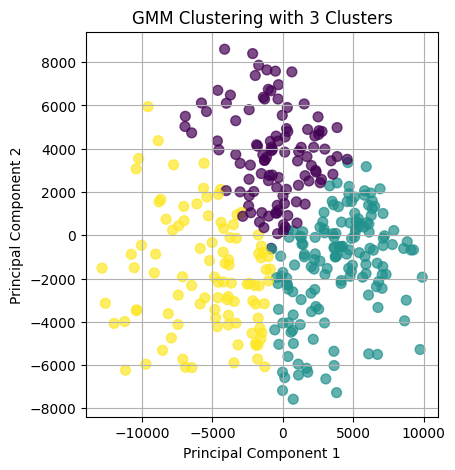

In [ ]:
# Plotting the clustering results and metrics
plt.figure(figsize=(10, 5))

# Scatter plot of clusters
plt.subplot(1, 2, 1)
plt.scatter(pca_transformed_images[:, 0], pca_transformed_images[:, 1], c=predicted_labels, cmap='viridis', s=50, alpha=0.7)
plt.title("GMM Clustering with 3 Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)

***6. C) Use the model to generate 20 new rocks (using the sample() method), and visualize them in the original image space (since you used PCA, you will need to use its inverse_transform() method).***

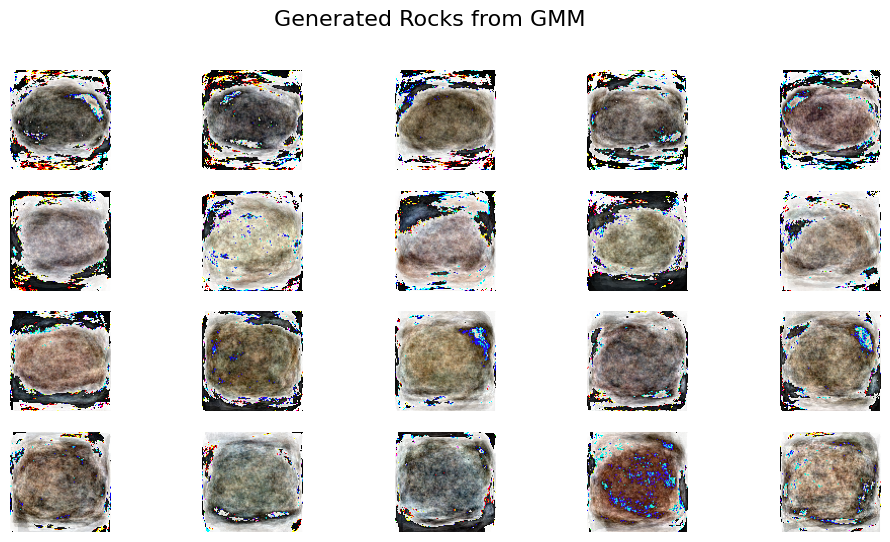

In [ ]:
# Generate 20 new samples from the Gaussian Mixture Model (GMM)
generated_samples = gmm_model.sample(n_samples=20)[0]
reconstructed_images = pca_model.inverse_transform(generated_samples)

plt.figure(figsize=(12, 6))
for idx in range(20):
    plt.subplot(4, 5, idx + 1)
    image = reconstructed_images[idx].reshape(100, 100, 3).astype(np.uint8)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.suptitle('Generated Rocks from GMM', fontsize=16)
plt.show()

*The results from generating new samples using the **Gaussian Mixture Model (GMM)** show that:*

*- The generated rock images appear blurry and lack distinct features, indicating that the GMM struggled to capture the detailed structure of the original rock images. This suggests that the model has learned a very generalized representation of the data, resulting in samples that are not well-defined.*

*- The generated samples look very similar to each other, suggesting that the GMM model may have converged to a limited subset of modes. This indicates poor diversity in the generated data, likely due to insufficient differentiation in the underlying feature space.*

**7. Build a feedforward neural network (using dense and/or CNN layers) with a few hidden layers in Keras (TensorFlow) or PyTorch. Train it on 360 rock images with rock name labels (I, M, S). Use images from the '120 Rocks' folder for validation. Set an appropriate number of neurons, with the last layer before softmax having 8 neurons. Use ReLU activation in the hidden layers and train until convergence. Adjust the learning rate and simplify the network if training is slow. Aim for performance above chance, showing decreasing loss and increasing accuracy on both train and validation sets. Colab with GPU (Edit -> Notebook settings) is recommended.**

In [ ]:
!pip install tensorflow

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Loading images
def load_images(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            img = Image.open(os.path.join(directory, filename))
            img = img.resize((100, 100))
            img_array = np.array(img) / 255.0  # Normalizing images
            images.append(img_array)
            label = filename[0]
            labels.append(label)
    return np.array(images), np.array(labels)

# Loading training and validation data
train_images, train_labels = load_images('/content/drive/My Drive/Data/360rocks/images/')
validation_images, validation_labels = load_images('/content/drive/My Drive/Data/120 Rocks/')

label_encoder = LabelEncoder()
unique_labels = np.unique(np.concatenate((train_labels, validation_labels)))
label_encoder.fit(unique_labels)
train_labels_encoded = label_encoder.transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)
num_classes = len(label_encoder.classes_)

train_labels_categorical = to_categorical(train_labels_encoded, num_classes=num_classes)
validation_labels_categorical = to_categorical(validation_labels_encoded, num_classes=num_classes)

# Applying data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Applying data augmentation to training batch
train_augmented_gen = datagen.flow(
    train_images, train_labels_categorical,
    batch_size=32,
    shuffle=True
)

# Applying data augmentation to validation batch
validation_augmented_gen = datagen.flow(
    validation_images, validation_labels_categorical,
    batch_size=32,
    shuffle=False
)

print("Training data augmentation:")
print(f"Number of training samples: {len(train_images)}")

print("\nValidation data augmentation:")
print(f"Number of validation samples: {len(validation_images)}")

Training data augmentation:
Number of training samples: 360

Validation data augmentation:
Number of validation samples: 120


*We have now loaded, resized and normalized images from specified directories while extracting labels from filenames. The data is seperated into training and validation sets, preparing it for model training.*

In [ ]:
import tensorflow as tf
# Defining the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPool2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),

    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # Multi-class classification
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

*- We have now defined a model which is a deep convolutional neural network (CNN) designed for multi-class classification with three output classes. It includes multiple convolutional layers for feature extraction, followed by dense layers for classification.*

*- We used `softmax` in the final layer cause it suits tasks requiring probabilities for each class. The model is compiled with the Adam optimizer and categorical cross-entropy loss, making it well-suited for handling one-hot encoded target labels.*

In [ ]:
# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25, restore_best_weights=False)

In [ ]:
# Training the model
import time
start_time = time.time()

history=model.fit(train_augmented_gen, validation_data=train_augmented_gen, epochs=100, batch_size=80, verbose=1,callbacks=[])

end_time = time.time()

# Model Evaluation
loss, accuracy = model.evaluate(validation_augmented_gen)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3552 - loss: 1.1285 - val_accuracy: 0.3333 - val_loss: 1.0969
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 974ms/step - accuracy: 0.3044 - loss: 1.1068 - val_accuracy: 0.3472 - val_loss: 1.0883
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3629 - loss: 1.0810 - val_accuracy: 0.4278 - val_loss: 1.0577
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 759ms/step - accuracy: 0.3850 - loss: 1.0882 - val_accuracy: 0.4556 - val_loss: 1.0625
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 889ms/step - accuracy: 0.4400 - loss: 1.0579 - val_accuracy: 0.4250 - val_loss: 1.0563
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 981ms/step - accuracy: 0.4073 - loss: 1.0455 - val_accuracy: 0.4222 - val_loss: 1.0525
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 980ms/step - accuracy: 0.4617 - loss: 1.0417 - val_accuracy: 0.4972 - val_loss: 1.0275
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 953ms/step - accuracy: 0.4952 - loss: 1.0057 - val_ac

*- Throughout the 100 epochs, the model demonstrates a clear improvement in training accuracy, increasing from around 35% to 62% by epoch 99. This suggests that the model is learning and adjusting its weights effectively. However, there seems to be some volatility, with the accuracy fluctuating in certain epochs, particularly between 40% and 60%, which could indicate overfitting or instability in training.*

*- While the training accuracy improves, the validation accuracy lags behind, reaching a peak around 65% in epoch 99 before dipping again. The validation loss fluctuates as well, which could indicate issues such as overfitting, where the model performs well on the training set but struggles to generalize to new, unseen data.*

*- After experimentation with various model architectures, the current results represent the best performance achieved so far, so we will proceed with this. Key observations during our trials include*:

- *Simpler models outperformed more complex ones, indicating that a less intricate architecture was more effective for this task.*


 - *Training beyond 100 epochs did not improve accuracy, suggesting that the model had reached its learning capacity.*

- *Data augmentation proved beneficial, as it enhanced the model's ability to generalize better.*



**7. A) Report the training time**

In [ ]:
# Calculating the total training time
training_time = end_time - start_time
print(f"Total time of training : {training_time:.2f} seconds")

Total time of training : 1472.16 seconds


**7. B) Plot training and validation loss and accuracy as a function of training epochs.**

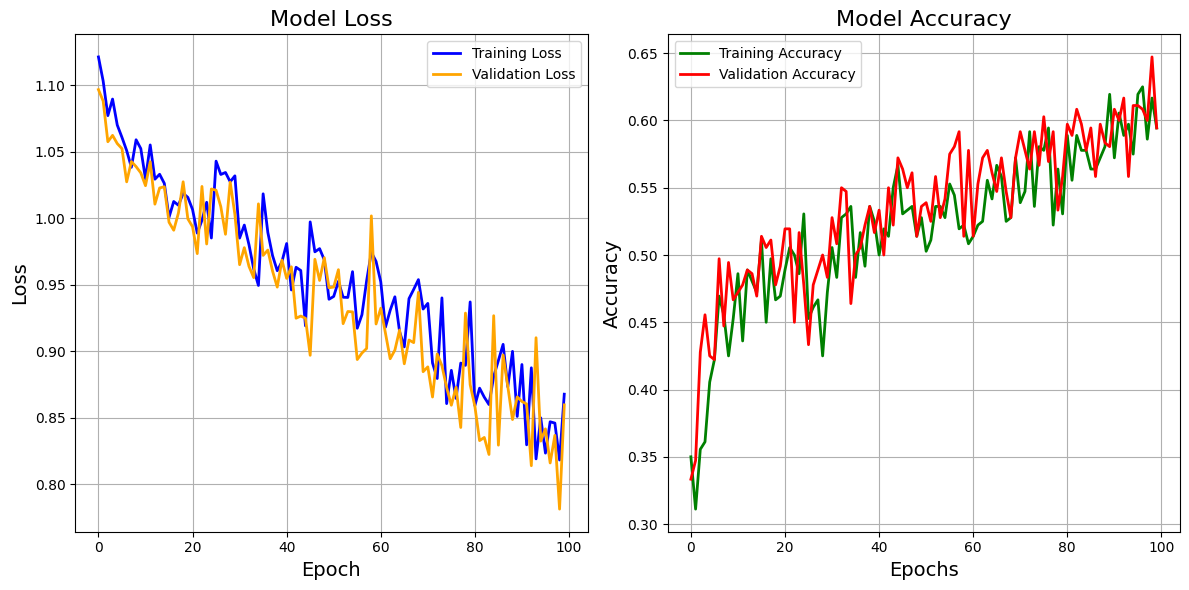

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Plotting training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title('Model Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid()

# Plotting training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
plt.title('Model Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

*- The loss curves (training in blue, validation in orange) show significant fluctuations across epochs, indicating that the model's learning process is somewhat unstable. While both losses decrease overall, the irregularity suggests that the model may be sensitive to the learning rate or data variations.*
  
*- The training and validation losses do not converge smoothly, which might indicate overfitting or the need for further regularization.*

*- The accuracy plots (training in green, validation in red) also display high variability, especially in the early epochs. Although there is some improvement over time, the fluctuations imply that the model struggles to generalize well on the validation set.*
   

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 2, 2, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 8)                   │           1,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,733,859 (6.61 MB)

 Trainable params: 1,733,859 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

*- Our model has a high number of parameters (1.7 million), especially in the deeper layers, which could have increased the risk of overfitting, which we can also see in the plots.*

*- The dense layer with 8 neurons before the final output layer seems redundant and may not contribute significantly to performance. Simplifying this could help optimize the model.*

**7. C) How many parameters does the network have? How many of those parameters are bias parameters?**

In [ ]:
# Number of parameters
total_params = model.count_params()

# Number of bias parameters
bias_params = sum([np.prod(p.shape) for p in model.trainable_weights if 'bias' in p.name])

print(f"Number of Parameters in Network: {total_params:,}")
print(f"Number of Bias Parameters in Network: {bias_params:,}")

Number of Parameters in Network: 1,733,859
Number of Bias Parameters in Network: 1,387


***7. D) Compare the activity of neurons in the next to the last layer (the one with 8 neurons) with the human data. (to get human data use mds_360.txt and mds_120.txt files). Similar to before, use Procrustes analysis to do the comparison.  For training and validation data (separately), report disparity and compute the correlation coefficient between each dimension of mtx1 and mtx2. Display results in a table.***

In [ ]:
from scipy.spatial import procrustes
from keras.models import Model

def activation(model, X, layer_idx=-2):
    inter_model = Model(inputs=model.input, outputs=model.layers[layer_idx].output)
    activations = inter_model.predict(X)
    return activations

# Loading MDS data
mds_360 = np.loadtxt('/content/drive/My Drive/Data/mds_360.txt')
mds_120 = np.loadtxt('/content/drive/My Drive/Data/mds_120.txt')

active_train = activation(model, train_images)
active_val = activation(model, validation_images)

min_dim_train = min(mds_360.shape[1], active_train.shape[1])
mds_360_train = mds_360[:, :min_dim_train]
active_train = active_train[:, :min_dim_train]
mtx1_train, mtx2_train, disparity_train = procrustes(mds_360_train, active_train)
correlation_coefficients_train = np.corrcoef(mtx1_train.T, mtx2_train.T)[:mtx1_train.shape[1], mtx1_train.shape[1]:]

table_result = pd.DataFrame(correlation_coefficients_train,
                            columns=[f'Dimension {i+1}' for i in range(min_dim_train)],
                            index=[f'Dimension {i+1}' for i in range(min_dim_train)])


4/4 [==============================] - 15s 4s/step


In [ ]:
# Disparity and corr table for training data
print("\n=== Training Results ===\n")
print(f"\nDisparity Result: {disparity_train:.4f}")
print("Correlation table: \n")
print(table_result)


=== Training Results ===


Disparity Result: 0.9898
Correlation table: 

             Dimension 1  Dimension 2  Dimension 3  Dimension 4  Dimension 5  \
Dimension 1     0.057009    -0.033626    -0.035676     0.038506    -0.034748   
Dimension 2    -0.098369     0.116290     0.113920    -0.109220     0.112467   
Dimension 3    -0.112735     0.123056     0.122152    -0.117315     0.120655   
Dimension 4     0.051568    -0.050000    -0.049719     0.060334    -0.050070   
Dimension 5    -0.145540     0.161025     0.159924    -0.156595     0.160843   
Dimension 6     0.095319    -0.103637    -0.102814     0.104272    -0.101209   
Dimension 7    -0.109842     0.095196     0.096094    -0.103203     0.095906   
Dimension 8     0.054162    -0.065436    -0.065000     0.068020    -0.065747   

             Dimension 6  Dimension 7  Dimension 8  
Dimension 1     0.035724    -0.042197     0.031730  
Dimension 2    -0.113628     0.106982    -0.112145  
Dimension 3    -0.121765     0.116652    -0.12

*- We used Procrustes analysis to compare the alignment of two sets of multidimensional data: `mds_360` and the activations extracted from the model's penultimate layer. The `disparity_train` metric represents how well these two datasets align after scaling, translation, and rotation.*

*- A low disparity indicates that the model’s learned features are well-aligned with the predefined MDS data, while a high value (like 0.9898) suggests some misalignment or differences in feature spaces.*

*- The correlation table (`correlation_coefficients_train`) indicates how similar each dimension of the model's learned representation is to the corresponding dimension in the MDS data.*

*- Low correlations (close to zero) suggest that the model's learned features are not directly aligned with the dimensions of the MDS space, implying that the model is learning distinct feature representations that may not be captured by the MDS embeddings.*

In [ ]:
# Disparity and corr table for validation data
min_dimensions_val = min(mds_120.shape[1], active_val.shape[1])
mds_120_val = mds_120[:, :min_dimensions_val]
active_val = active_val[:, :min_dimensions_val]
mtx1_val, mtx2_val, disparity_val = procrustes(mds_120_val, active_val)
correlation_coefficients_val = np.corrcoef(mtx1_val.T, mtx2_val.T)[:mtx1_val.shape[1], mtx1_val.shape[1]:]

val_result_table = pd.DataFrame(correlation_coefficients_val,
                                columns=[f'Dimension {i+1}' for i in range(min_dimensions_val)],
                                index=[f'Dimension {i+1}' for i in range(min_dimensions_val)])

print("\n=== Validation Results ===\n")
print(f"\nDisparity Result: {disparity_val:.4f}")
print("Correlation table: \n")
print(val_result_table)


=== Validation Results ===


Disparity Result: 0.9950
Correlation table: 

             Dimension 1  Dimension 2  Dimension 3  Dimension 4  Dimension 5  \
Dimension 1     0.110450    -0.105784     0.102998    -0.110004    -0.081676   
Dimension 2    -0.114532     0.116377    -0.115025     0.120909     0.156118   
Dimension 3     0.072294    -0.074569     0.076804    -0.078641    -0.059759   
Dimension 4    -0.032318     0.032809    -0.032916     0.044188     0.043665   
Dimension 5    -0.002029     0.003581    -0.002115     0.003692     0.052602   
Dimension 6    -0.010352     0.006660    -0.004115     0.012522     0.009749   
Dimension 7    -0.026119     0.024297    -0.022907     0.019590     0.019747   
Dimension 8    -0.046055     0.044943    -0.045212     0.045254     0.026659   

             Dimension 6  Dimension 7  Dimension 8  
Dimension 1    -0.143563    -0.107382    -0.103747  
Dimension 2     0.099998     0.108152     0.109615  
Dimension 3    -0.040061    -0.066104    -0.

*- The disparity result is approximately **0.9950**, which is even higher than the training disparity of **0.9898**. This indicates that the model's learned representations on the validation set are not well-aligned with the MDS data, suggesting a possible lack of generalization.*

*- The correlation coefficients between the model’s learned features and the MDS embeddings for the validation data are mostly close to zero. This suggests that the model’s internal feature representations are not directly correlated with the predefined MDS space, implying that the model captures different patterns from the validation data compared to the training data.*

*- These results indicate that while the model is learning distinct features, it may not be aligning well with the expected feature space defined by MDS, possibly affecting its generalization capability.*

References:

- https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.PCA.html
- https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html
- https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
- https://www.tensorflow.org/ https://www.tensorflow.org/tutorials/images/cnn